### Redes Neurais e Arquiteturas Profundas
#### **MBA em Ciências de Dados**

### *Módulo 3 - Redes Neurais Convolucionais (CNNs)*

**Explorando alternativas para arquiteturas de CNNs**

Moacir A. Ponti

---

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

## 1. Carregar e preparar base de dados

In [8]:
# Carregando dataset a partir de TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train[:20%]', 'test[:25%]'], 
                                         as_supervised=True, with_info=True)
num_classes = ds_info.features['label'].num_classes

In [10]:
# Get the image resolution
input_shape = ds_info.features['image'].shape

# Get the size of each set
num_train_examples = tf.data.experimental.cardinality(ds_train).numpy()
num_test_examples = tf.data.experimental.cardinality(ds_test).numpy()

# Get the number of classes
num_classes = ds_info.features['label'].num_classes

# Print the obtained information
print(f"Resolução: {input_shape}")
print(f"Training Set: {num_train_examples} exemplos")
print(f"Testing Set: {num_test_examples} exemplos")
print(f"Classes: {num_classes}")

Resolução: (32, 32, 3)
Training Set: 10000 exemplos
Testing Set: 2500 exemplos
Classes: 10


2023-10-02 11:46:29.151908: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


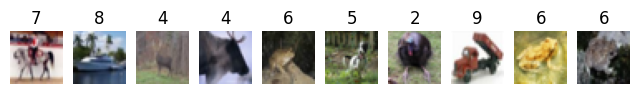

In [13]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(8, 3))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{label}")
    plt.show()

# extrai primeiras 10 imagens para exibir
list_images = []
list_labels = []
for example in ds_train.take(10):
    image = example[0].numpy()
    label = example[1].numpy()
    list_images.append(image)
    list_labels.append(label)
    
show_images(list_images, list_labels)

In [14]:
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label
    
# Pre-processa imagens
def preprocess_image(image, label):
    # converte imagem para float32
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

ds_train = ds_train.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

ds_train = ds_train.map(one_hot_label)
ds_test = ds_test.map(one_hot_label)

#### Preparar os batches

In [44]:
# vamos usar o mesmo número de épocas e batchsize para ambos
batch_size = 64

# definindo o batch size para iterar sobre o dataset
ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)

## 2. Projetar redes neurais

### 2.1 - CNN estilo "VGGNet"

In [85]:
CNN1 = keras.Sequential()
CNN1.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), 
                             padding='valid', activation='relu', 
                             input_shape=input_shape))
CNN1.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN1.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),  
                             padding='same', activation='relu'))
CNN1.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1),  
                             padding='same', activation='relu'))
CNN1.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
CNN1.add(keras.layers.Flatten())
CNN1.add(keras.layers.Dense(64, activation='relu'))
CNN1.add(keras.layers.Dense(10, activation='softmax'))
CNN1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_111 (Conv2D)         (None, 15, 15, 64)        18496     
                                                                 
 conv2d_112 (Conv2D)         (None, 15, 15, 64)        36928     
                                                                 
 conv2d_113 (Conv2D)         (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                               

### 2.2 - Substituição de MaxPooling por strides > 1

In [87]:
# Algumas alternativas: uso de stride ao invés de MaxPooling e uso de tamanhos de filtro diferentes: ao inves de 3x3, usamos 1x3, 3x1 e 1x1
CNN2 = keras.Sequential()
CNN2.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), 
                             padding='valid', activation='relu', input_shape=input_shape))
CNN2.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), 
                             padding='same', activation='relu'))
CNN2.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN2.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), 
                             padding='same', activation='relu'))
CNN2.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN2.add(keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), 
                             padding='same', activation='relu'))
CNN2.add(keras.layers.Flatten())
CNN2.add(keras.layers.Dense(64, activation='relu'))
CNN2.add(keras.layers.Dense(10, activation='softmax'))
CNN2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_123 (Conv2D)         (None, 15, 15, 64)        18496     
                                                                 
 conv2d_124 (Conv2D)         (None, 15, 15, 64)        36928     
                                                                 
 conv2d_125 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_126 (Conv2D)         (None, 8, 8, 64)          36928     
                                                                 
 conv2d_127 (Conv2D)         (None, 4, 4, 64)          36928     
                                                                 
 flatten_20 (Flatten)        (None, 1024)            

### 2.3 - Uso de convoluções por partes 1x3, 3x1, 1x1 

(como usado por Inception, mas aqui não estão em paralelo, apenas em sequência)

In [112]:
# Algumas alternativas: uso de stride ao invés de MaxPooling e 
# uso de tamanhos de filtro diferentes: ao inves de 3x3, usamos 1x3, 3x1 e 1x1
CNN3 = keras.Sequential()
CNN3.add(keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), 
                             padding='valid', activation='relu', 
                             input_shape=input_shape))
CNN3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
CNN3.add(keras.layers.Conv2D(32, kernel_size=(1,3), strides=(1,1), 
                             padding='same', activation='relu'))
CNN3.add(keras.layers.Conv2D(32, kernel_size=(3,1), strides=(1,1), 
                             padding='same', activation='relu'))
CNN3.add(keras.layers.Conv2D(32, kernel_size=(1,1), strides=(1,1),  
                             padding='same', activation='relu'))
CNN3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
CNN3.add(keras.layers.Conv2D(64, kernel_size=(1,3), strides=(1,1),  
                             padding='same', activation='relu'))
CNN3.add(keras.layers.Conv2D(64, kernel_size=(3,1), strides=(1,1),  
                             padding='same', activation='relu'))
CNN3.add(keras.layers.Conv2D(64, kernel_size=(1,1), strides=(1,1),  
                             padding='same', activation='relu'))
CNN3.add(keras.layers.Flatten())
CNN3.add(keras.layers.Dense(64, activation='relu'))
CNN3.add(keras.layers.Dense(10, activation='softmax'))
CNN3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_196 (Conv2D)         (None, 15, 15, 32)        3104      
                                                                 
 conv2d_197 (Conv2D)         (None, 15, 15, 32)        3104      
                                                                 
 conv2d_198 (Conv2D)         (None, 15, 15, 32)        1056      
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 7, 7, 32)          0         
 ng2D)                                               

### 2.4 - Blocos Residuais (estilo ResNet)

In [89]:
def residual_block(x, n_filters, kernel_size=3, strides=1):
    # skip conection
    skip_connection = x
    
    # Primeira camada convolucional
    x = keras.layers.Conv2D(n_filters, kernel_size=kernel_size, 
                            strides=strides, activation='linear', 
                            padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    # Segunda camada convolucional
    x = keras.layers.Conv2D(n_filters, kernel_size=kernel_size, 
                            strides=strides, activation='linear', 
                            padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    # Adição da saída antes das camadas
    x = keras.layers.add([x, skip_connection])
    x = keras.layers.Activation('relu')(x)
    
    return x


Para usar a função `residual_block` é melhor montar a rede usando o modo "funcional"

In [90]:
def ResNetCNN(input_shape, num_classes, n_filters=32):
    
    input_tensor = keras.layers.Input(shape=input_shape)
    x = input_tensor

    x = keras.layers.Conv2D(n_filters, kernel_size=3, strides=1, 
                            activation='relu', padding='same')(x)
    
    # Blocos residuais + MaxPooling
    x = residual_block(x, n_filters=n_filters)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    x = residual_block(x, n_filters=n_filters)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    # Achatar a saída do bloco residual
    x = keras.layers.Flatten()(x)
    
    # Camada densa/fully connected
    x = keras.layers.Dense(128, activation='relu')(x)
    
    output_tensor = keras.layers.Dense(num_classes, activation='softmax')(x)  
    
    # Cria o modelo com base na entrada e saída
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)

    return model


In [91]:
CNN_res = ResNetCNN(input_shape, 10)
CNN_res.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_148 (Conv2D)         (None, 32, 32, 32)           896       ['input_13[0][0]']            
                                                                                                  
 conv2d_149 (Conv2D)         (None, 32, 32, 32)           9248      ['conv2d_148[0][0]']          
                                                                                                  
 batch_normalization_32 (Ba  (None, 32, 32, 32)           128       ['conv2d_149[0][0]']          
 tchNormalization)                                                                          

### 2.5 - Blocos Separáveis em Profundidade (estilo Xception/MobileNet)

In [92]:
def XceptionCNN(input_shape, num_classes, n_filters=32, blocks=3):
    
    input_tensor = keras.layers.Input(shape=input_shape)
    x = input_tensor

    x = keras.layers.Conv2D(n_filters, kernel_size=3, strides=1, 
                            activation='relu', padding='same')(x)
    
    # Blocos separaveis em profundidade + MaxPooling
    x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, 
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, 
                                     padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    # Achatar a saída do bloco residual
    x = keras.layers.Flatten()(x)
    
    # Camada densa/fully connected
    x = keras.layers.Dense(128, activation='relu')(x)
    
    output_tensor = keras.layers.Dense(num_classes, activation='softmax')(x)  
    
    # Cria o modelo com base na entrada e saída
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)

    return model


In [93]:
CNN_x = XceptionCNN(input_shape, 10)
CNN_x.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_153 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 depthwise_conv2d_4 (Depthw  (None, 32, 32, 32)        320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_35 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 16, 16, 32)        0   

# 3. Compilando Modelos

In [113]:
# as sementes ajudam a ter resultados reproduzíveis
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

CNN1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

CNN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

CNN3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

CNN_res.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

CNN_x.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])


# 4. Executando o treinamento

In [96]:
epochs = 15

In [97]:
hist1 = CNN1.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, verbose=0)

score1_Tr = CNN1.evaluate(ds_train, verbose = 0)
score1_Te = CNN1.evaluate(ds_test, verbose = 0)

In [98]:
hist2 = CNN2.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, verbose=0)

score2_Tr = CNN2.evaluate(ds_train, verbose = 0)
score2_Te = CNN2.evaluate(ds_test, verbose = 0)

In [114]:
hist3 = CNN3.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, verbose=0)

score3_Tr = CNN3.evaluate(ds_train, verbose = 0)
score3_Te = CNN3.evaluate(ds_test, verbose = 0)

In [100]:
hist4 = CNN_res.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, verbose=0)

score4_Tr = CNN_res.evaluate(ds_train, verbose = 0)
score4_Te = CNN_res.evaluate(ds_test, verbose = 0)

In [101]:
hist5 = CNN_x.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, verbose=0)

score5_Tr = CNN_x.evaluate(ds_train, verbose = 0)
score5_Te = CNN_x.evaluate(ds_test, verbose = 0)

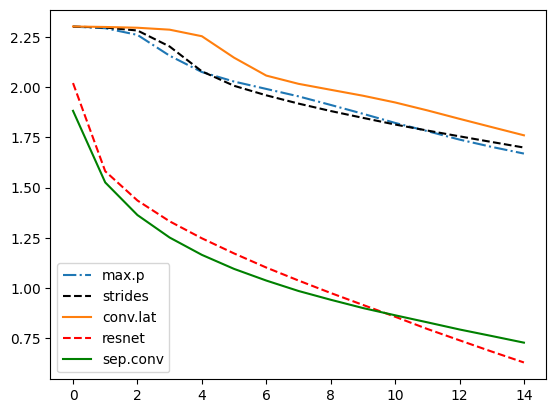

In [115]:
plt.plot(hist1.history['loss'], '-.')
plt.plot(hist2.history['loss'], '--k')
plt.plot(hist3.history['loss'], '-')
plt.plot(hist4.history['loss'], '--r')
plt.plot(hist5.history['loss'], '-g')

plt.legend(["max.p", "strides", "conv.lat", "resnet", "sep.conv"], loc="lower left")

In [116]:
print("Acurácia Treinamento")
print(f"CNN max.pool : {(score1_Tr[1])*100:.1f}")
print(f"CNN strides  : {(score2_Tr[1])*100:.1f}")
print(f"CNN conv.lat : {(score3_Tr[1])*100:.1f}")
print(f"CNN resnet   : {(score4_Tr[1])*100:.1f}")
print(f"CNN sep.conv : {(score5_Tr[1])*100:.1f}\n")

print("Acurácia Teste")
print(f"CNN max.pool : {(score1_Te[1])*100:.1f}")
print(f"CNN strides  : {(score2_Te[1])*100:.1f}")
print(f"CNN conv.lat : {(score3_Te[1])*100:.1f}")
print(f"CNN resnet   : {(score4_Te[1])*100:.1f}")
print(f"CNN sep.conv : {(score5_Te[1])*100:.1f}")

Acurácia Treinamento
CNN max.pool : 39.1
CNN strides  : 40.0
CNN conv.lat : 36.9
CNN resnet   : 71.0
CNN sep.conv : 67.7

Acurácia Teste
CNN max.pool : 38.7
CNN strides  : 40.1
CNN conv.lat : 38.0
CNN resnet   : 55.2
CNN sep.conv : 56.0
